In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [80]:
df = pd.read_csv('iris.csv')
df.head()
encoder = OneHotEncoder(sparse_output=False)
y = df['Species'].values
y = encoder.fit_transform(y.reshape(-1, 1))
X = df.drop(columns=['Species', 'Id'], axis=1).values
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optimizer

In [106]:
class AdagradOptimizer:
    def __init__(self, parameters, learning_rate=0.01, eps=1e-8):
        self.parameters = parameters
        self.lr = learning_rate
        self.eps = eps
        self.G = [np.zeros_like(p) for p in self.parameters]

    def update(self, grads):
        for i in range(len(self.parameters)):
            self.G[i] += grads[i] ** 2
            adjusted_lr = self.lr / (np.sqrt(self.G[i]) + self.eps)
            self.parameters[i] -= adjusted_lr * grads[i]
        return self.parameters[0], self.parameters[1]

# Функция активации

In [107]:
class ActivationFunction:
    def __init__(self, name):
        if name == 'identity':
            self.func = self.identity
            self.derivative = self.identity_derivative
        elif name == 'relu':
            self.func = self.relu
            self.derivative = self.relu_derivative
        elif name == 'tanh':
            self.func = np.tanh
            self.derivative = lambda x: 1 - np.tanh(x) ** 2
        else:
            raise ValueError(f"Unknown activation function: {name}")

    def identity(self, x):
        return x

    def identity_derivative(self, x):
        return np.ones_like(x)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def __call__(self, x):
        return self.func(x)

# Слои

$z = W x + b$

$y = f(z)$

$\frac{\partial L}{\partial z} = dy \circ f'(z)$

Градиент по W:

&ensp;&ensp;$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z} \cdot x^\top$

Градиент по x:

&ensp;&ensp;$\frac{\partial L}{\partial x} = W^\top \cdot \frac{\partial L}{\partial z}$

Градиент по bias:

&ensp;&ensp;$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial z}$

In [108]:
class Layer:
    def __init__(self, input_dim, output_dim, activation='relu', learning_rate=0.01):
        self.W = np.random.randn(input_dim, output_dim) * 0.01
        self.b = np.zeros(output_dim)
        self.activation = ActivationFunction(activation)

        self.x = None
        self.z = None
        self.dW = None
        self.db = None
        self.optimizer = AdagradOptimizer([self.W, self.b], learning_rate=learning_rate)

    def forward(self, x):
        self.x = x
        self.z = self.x @ self.W + self.b
        return self.activation(self.z)

    def backward(self, dy):
        dz = self.activation.derivative(self.z) * dy  # dL/dz
        self.dW = np.outer(self.x, dz)              # dL/dW
        self.db = dz   # dL/db
        dx = dz @ self.W.T                           # dL/dx
        return dx
    
    def update(self):
        self.W, self.b = self.optimizer.update([self.dW, self.db])

Пусть:

$z_j = \exp\left(-\frac{1}{2\sigma^2} \|x - w_j\|^2 \right) + b_j
\quad\text{и}\quad
a_j = \phi(z_j)$

Обозначим:

$
\delta_j = \frac{\partial \mathcal{L}}{\partial a_j} \cdot \phi'(z_j)
$

Градиенты:

$
\frac{\partial \mathcal{L}}{\partial b_j} = \delta_j
$

$
\frac{\partial \mathcal{L}}{\partial w_j} = \delta_j \cdot \frac{1}{\sigma^2} (x - w_j) \cdot \exp\left(-\frac{1}{2\sigma^2} \|x - w_j\|^2 \right)
$

$
\frac{\partial \mathcal{L}}{\partial x} = \sum_{j=1}^m \left( -\delta_j \cdot \frac{1}{\sigma^2} (x - w_j) \cdot \exp\left(-\frac{1}{2\sigma^2} \|x - w_j\|^2 \right) \right)
$


In [118]:
class LayerRBF:
    def __init__(self, input_dim, output_dim, activation='relu', sigma=1.0, learning_rate=0.01):
        self.W = np.random.randn(input_dim, output_dim)
        self.sigma = sigma
        self.activation = ActivationFunction(activation)
        self.b = np.zeros(output_dim)
        self.x = None
        self.y = None
        self.dW = None
        self.optimizer = AdagradOptimizer([self.W, self.b], learning_rate=learning_rate)
        self.output_dim = output_dim
        self.input_dim = input_dim


    def rbf(self, x, c):
        diff = x - c
        return np.exp(-np.sum(diff**2) / (2 * self.sigma**2))

    def forward(self, x):
        self.x = x
        self.z = np.zeros(self.output_dim)

        for j in range(self.output_dim):
            r = self.rbf(x, self.W[:, j])
            self.z[j] = r + self.b[j]

        return self.activation(self.z)

    def backward(self, dy):
        dz = self.activation.derivative(self.z) * dy
        self.db = dz.copy()
        self.dW = np.zeros_like(self.W)
        dx = np.zeros_like(self.x)

        for j in range(self.output_dim):
            diff = self.x - self.W[:, j]
            r = self.rbf(self.x, self.W[:, j])
            grad_W = (1 / self.sigma**2) * diff * r * dz[j]
            grad_x = (-1 / self.sigma**2) * diff * r * dz[j]

            self.dW[:, j] = grad_W
            dx += grad_x

        return dx


    def update(self):
        self.W, self.b = self.optimizer.update([self.dW, self.db])

# SoftArgMaxCrossEntropy

In [110]:
class SoftArgMaxCrossEntropy:
    def __init__(self):
        self.probs = None 
        self.target = None

    def softArgMax(self, x):
        z = x - np.max(x)
        exp_z = np.exp(z)
        self.probs = exp_z / np.sum(exp_z)
        return self.probs

    def forward(self, x, target):
        self.target = target
        loss = -np.sum(target * np.log(self.softArgMax(x) + 1e-12))
        return loss

    def backward(self):
        return self.probs - self.target


# Модели

In [111]:
class Model:
  def __init__(self, *models):
    self.models = models

  def forward(self, x):
    for m in self.models:
      x = m.forward(x)
    return x

  def backward(self, grad):
    for m in self.models[::-1]:
      grad = m.backward(grad)

  def update(self):
    for m in self.models:
      m.update()

In [13]:
from sklearn.metrics import accuracy_score
def accuracy(y_pred, y_test):
  return accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))

In [119]:
class ModelTrain:
  def __init__(self, model, loss_fn=SoftArgMaxCrossEntropy()):
    self.model = model
    self.loss_fn = loss_fn

  def fit(self, x_train, y_train, iterations=300):
    losses = []
    for i in range(iterations):
      total_loss = 0
      for x, y in zip(x_train, y_train):
        p = self.model.forward(x)
        loss = self.loss_fn.forward(p, y)
        grad = self.loss_fn.backward()
        self.model.backward(grad)
        self.model.update()
        total_loss += loss
      losses.append(total_loss / len(x_train))
    return losses

  def predict(self, x_test):
    y_predict = []
    for x in x_test:
      p = self.loss_fn.softArgMax(self.model.forward(x))
      y_predict.append(p)
    return np.array(y_predict)

input_size = X_train.shape[1]
output_size = y_train.shape[1]

In [ ]:
def train_and_show(models, iterations=300):
    results = {}
    plt.figure(figsize=(12, 5))

    for name, model in models.items():
        trainer = ModelTrain(model)
        losses = trainer.fit(X_train, y_train, iterations=iterations)
        preds = trainer.predict(X_test)
        acc = accuracy(preds, y_test)
        results[name] = {'accuracy': acc, 'final_loss': losses[-1]}
        plt.plot(losses, label=f'{name} (acc={acc:.2f})')

    plt.title("Loss over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.bar(results.keys(), [v['accuracy'] for v in results.values()])
    plt.ylabel("Accuracy")
    plt.title("Test Accuracy per Model")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return results

## 6

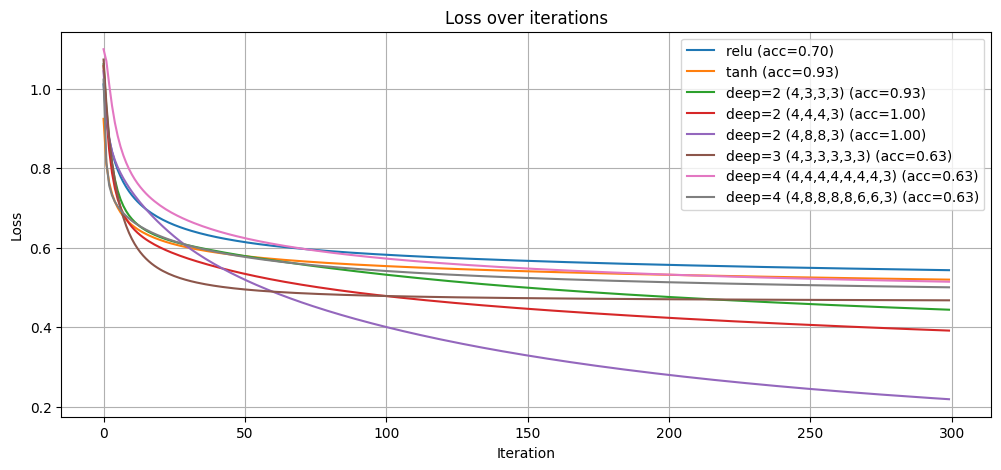

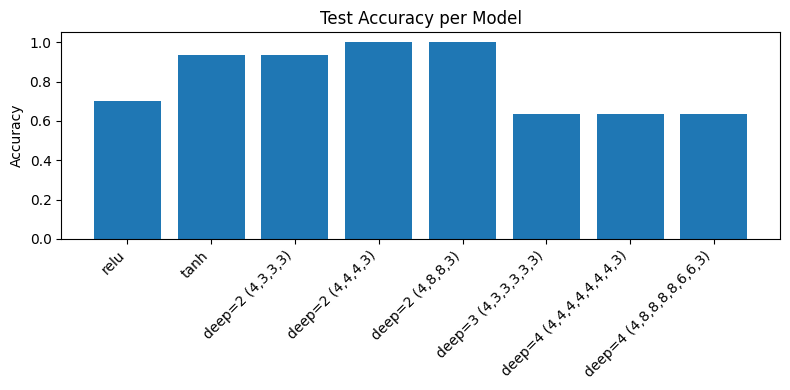

In [ ]:
r = train_and_show(
    {
      "relu": Model(Layer(input_size, output_size)),
      "tanh": Model(Layer(input_size, output_size, activation = 'tanh')),
      " deep=2 (4,3,3,3)": Model(Layer(input_size, output_size), Layer(output_size, output_size, activation='tanh')),
      "deep=2 (4,4,4,3)": Model(Layer(input_size, input_size), Layer(input_size, output_size, activation='tanh')),
      "deep=2 (4,8,8,3)": Model(Layer(input_size, 8), Layer(8, output_size, activation = 'identity')),
      "deep=3 (4,3,3,3,3,3)": Model(Layer(input_size, output_size), Layer(output_size, output_size, activation = 'tanh'), Layer(output_size, output_size, activation = 'identity')),
      "deep=4 (4,4,4,4,4,4,4,3)":  Model(Layer(input_size, input_size, activation = 'relu'), Layer(input_size, input_size, activation = 'tanh'), Layer(input_size, input_size, activation = 'relu'), Layer(input_size, output_size, activation = 'identity')),
      "deep=4 (4,8,8,8,8,6,6,3)": Model(Layer(input_size, 8, activation = 'relu'), Layer(8, 8, activation = 'tanh'), Layer(8, 6, activation = 'relu'), Layer(6, output_size, activation = 'identity')),
    }
)

## 7

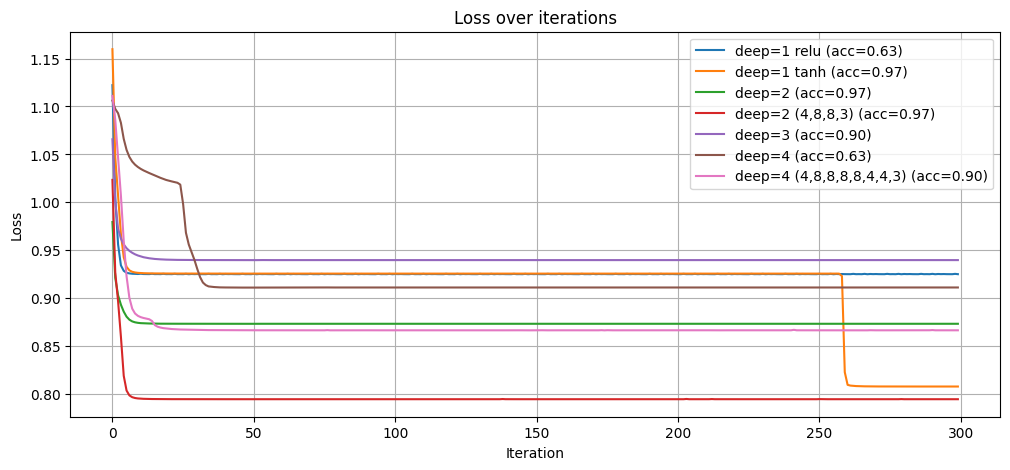

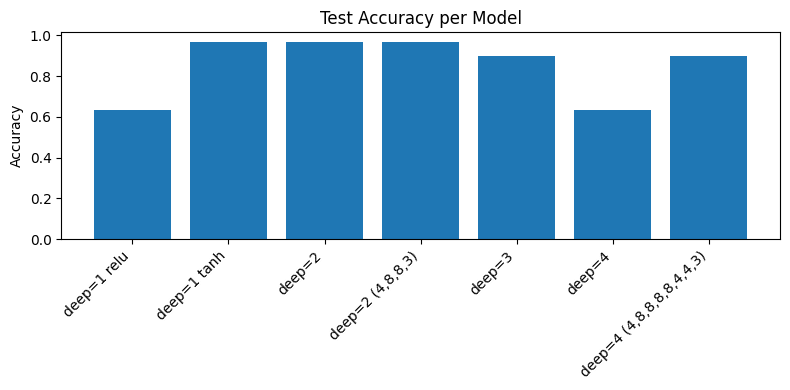

{'deep=1 relu': {'accuracy': 0.6333333333333333,
  'final_loss': 0.9250600530358934},
 'deep=1 tanh': {'accuracy': 0.9666666666666667,
  'final_loss': 0.8078500604854615},
 'deep=2': {'accuracy': 0.9666666666666667, 'final_loss': 0.8733111734106906},
 'deep=2 (4,8,8,3)': {'accuracy': 0.9666666666666667,
  'final_loss': 0.7946056948211828},
 'deep=3': {'accuracy': 0.9, 'final_loss': 0.9397434775652008},
 'deep=4': {'accuracy': 0.6333333333333333, 'final_loss': 0.9111820917823253},
 'deep=4 (4,8,8,8,8,4,4,3)': {'accuracy': 0.9,
  'final_loss': 0.8664995770980622}}

In [114]:
train_and_show(
    {
      "deep=1 relu": Model(LayerRBF(input_size, output_size)),
      "deep=1 tanh": Model(LayerRBF(input_size, output_size, activation = 'tanh')),
      "deep=2": Model(LayerRBF(input_size, output_size), LayerRBF(output_size, output_size, activation = 'tanh')),
      "deep=2 (4,8,8,3)": Model(LayerRBF(input_size, 8), LayerRBF(8, output_size, activation = 'identity')),
      "deep=3": Model(LayerRBF(input_size, output_size), LayerRBF(output_size, output_size, activation = 'tanh'), LayerRBF(output_size, output_size, activation = 'identity')),
      "deep=4": Model(LayerRBF(input_size, input_size, activation = 'relu'), LayerRBF(input_size, input_size, activation = 'tanh'), LayerRBF(input_size, input_size, activation = 'relu'), LayerRBF(input_size, output_size, activation = 'identity')),
      "deep=4 (4,8,8,8,8,4,4,3)": Model(LayerRBF(input_size, 8, activation = 'relu'), LayerRBF(8, 8, activation = 'tanh'), LayerRBF(8, 4, activation = 'relu'), LayerRBF(4, output_size, activation = 'identity')),
    }
)

## 8

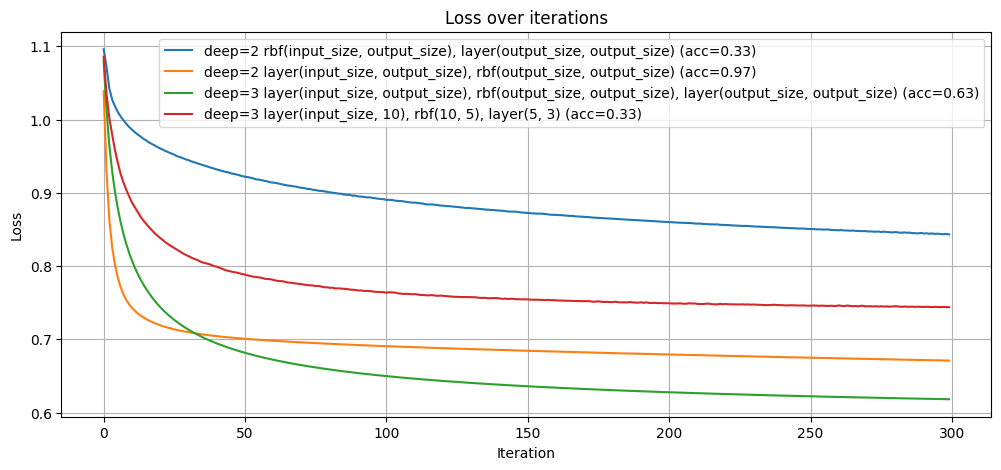

/tmp/ipykernel_716/763841684.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


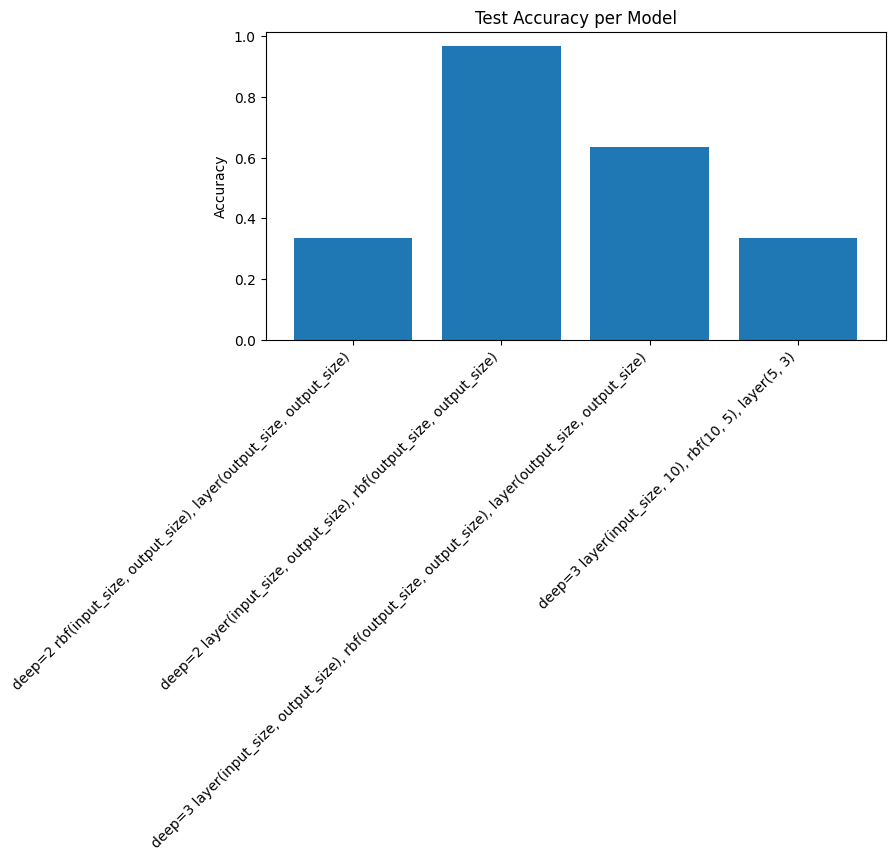

{'deep=2 rbf(input_size, output_size), layer(output_size, output_size)': {'accuracy': 0.3333333333333333,
  'final_loss': 0.8432326797561187},
 'deep=2 layer(input_size, output_size), rbf(output_size, output_size)': {'accuracy': 0.9666666666666667,
  'final_loss': 0.6710437393583207},
 'deep=3 layer(input_size, output_size), rbf(output_size, output_size), layer(output_size, output_size)': {'accuracy': 0.6333333333333333,
  'final_loss': 0.6182649148832944},
 'deep=3 layer(input_size, 10), rbf(10, 5), layer(5, 3)': {'accuracy': 0.3333333333333333,
  'final_loss': 0.7439059372006267}}

In [115]:
train_and_show(
    {
        "deep=2 rbf(input_size, output_size), layer(output_size, output_size)": Model(LayerRBF(input_size, output_size), Layer(output_size, output_size)),
        "deep=2 layer(input_size, output_size), rbf(output_size, output_size)": Model(Layer(input_size, output_size, activation='tanh'), LayerRBF(output_size, output_size)),
        "deep=3 layer(input_size, output_size), rbf(output_size, output_size), layer(output_size, output_size)": Model(Layer(input_size, output_size, activation = 'tanh'), LayerRBF(output_size, output_size, activation = 'tanh'), Layer(output_size, output_size, activation = 'tanh')),
        "deep=3 layer(input_size, 10), rbf(10, 5), layer(5, 3)": Model(Layer(input_size, 10, activation = 'tanh'), LayerRBF(10, 5, activation = 'tanh'), Layer(5, output_size, activation = 'relu')),
    }
)